In [ ]:
!pip install pydriller pandas torch transformers accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
# scripts/diff_with_llm_and_rectifier.py

import re
import csv
import pandas as pd
from pathlib import Path
from pydriller import Repository
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
import torch

# ---------------------------
# Paths
# ---------------------------
WORKSPACE_ROOT = Path(".")
BUGFIX_CSV = WORKSPACE_ROOT / "bugfix_commits.csv"
OUT_CSV = WORKSPACE_ROOT / "bugfix_diffs_with_llm_and_rectifier.csv"
REPO_URL = "https://github.com/agno-agi/agno.git"   # remote repo

# ---------------------------
# Load baseline LLM (CommitPredictorT5)
# ---------------------------
MODEL_NAME = "mamiksik/CommitPredictorT5"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def run_model(prompt: str, max_input_tokens: int = 512, max_output_tokens: int = 64) -> str:
    if not prompt.strip():
        return ""
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_tokens,
    ).to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_output_tokens,
            do_sample=False,
            temperature=None,
            top_p=None,
            top_k=None

        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# ---------------------------
# Rectifier model (stronger LLM, e.g. Qwen)
# ---------------------------
RECTIFIER_MODEL = "Qwen/Qwen2.5-3B-Instruct"

rect_tok = AutoTokenizer.from_pretrained(
    RECTIFIER_MODEL,
    trust_remote_code=True
)
rect_model = AutoModelForCausalLM.from_pretrained(
    RECTIFIER_MODEL,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
import gc
gc.collect()     # Clean Python objects
torch.cuda.empty_cache()  # Free GPU memory


In [16]:
def run_rectifier(dev_msg: str, llm_msg: str, proc_diff: str, max_new_tokens: int = 48) -> str:
    if not (proc_diff or dev_msg or llm_msg):
        return ""

    # Few-shot examples
    few_shot = [
        {"diff": "<del> def read()\n<add> def read(user_id)", "subject": "Add user_id argument to read()"},
        {"diff": "<add> logger = logging.getLogger(__name__)",
         "subject": "Add module-level logger"},
        {"diff": "<del> if x > 10:\n<add> if x >= 10:", "subject": "Fix off-by-one error in condition"},
        {"diff": "<del> requests.get(url)\n<add> httpx.get(url)",
         "subject": "Migrate calls from requests to httpx"},
    ]

    prompt_example = "".join(
        f"Diff:\n{ex['diff']}\nCommit subject: {ex['subject']}\n\n"
        for ex in few_shot
    )

    prompt_user = f"{prompt_example}Diff:\n{proc_diff[:2000]}\nCommit subject:"

    messages = [
        {"role": "system", "content": "You are an expert at writing clear, concise Git commit messages."},
        {"role": "user", "content": prompt_user},
    ]

    inputs = rect_tok.apply_chat_template(messages, return_tensors="pt").to(rect_model.device)
    attention_mask = inputs.ne(rect_tok.pad_token_id).long()

    with torch.no_grad():
        out = rect_model.generate(
            input_ids=inputs,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=None, # zero randomness
            top_p=None, top_k=None,
        )

    # Slice off the input part → only model continuation
    gen_tokens = out[0][inputs.shape[1]:]
    raw_output = rect_tok.decode(gen_tokens, skip_special_tokens=False)

    # --- Postprocess ---
    cleaned = (
        raw_output.replace("<|im_start|>", "")
                  .replace("<|im_end|>", "")
                  .replace("system", "")
                  .replace("user", "")
                  .strip()
    )

    # Extract subject safely
    try:
        if "Commit subject:" in cleaned:
            subject = cleaned.split("Commit subject:")[-1].strip().splitlines()[0]
        else:
            subject = cleaned.strip().splitlines()[0]
    except IndexError:
        subject = llm_msg or dev_msg or "Update code"

    # Fallback if invalid
    if not subject or len(subject.split()) < 2:
        subject = llm_msg or dev_msg or "Update code"

    # Cleanup
    subject = subject.rstrip(".!?")
    subject = enforce_git_style(subject)

    return subject


In [17]:
# ---------------------------
# Load bugfix hashes
# ---------------------------
bugfix_df = pd.read_csv(BUGFIX_CSV)
OUT_CSV = WORKSPACE_ROOT / "bugfix_diffs_with_llm_and_rectifier just.csv"

# Choose batch range manually
BATCH_START, BATCH_END = 300, 400   # <-- change these for each run
bugfix_hashes = set(bugfix_df["Hash"].iloc[BATCH_START:BATCH_END].tolist())
print(f" Limited bugfix_hashes to {len(bugfix_hashes)} "
      f"({BATCH_START}–{BATCH_END})")

# ---------------------------
# Diff preprocessing for T5
# ---------------------------
HEADER_PREFIXES = (
    "diff --git", "index ", "+++ ", "--- ", "rename from", "rename to",
    "similarity index", "new file mode", "deleted file mode",
)

def preprocess_diff(diff: str, max_lines: int = 240) -> str:
    """Preprocess unified diff for CommitPredictorT5 only."""
    if not diff:
        return ""
    lines = []
    for raw in diff.splitlines():
        if raw.startswith(HEADER_PREFIXES) or raw.startswith("@@"):
            continue
        if len(lines) >= max_lines:
            break
        if raw.startswith("+") and not raw.startswith("+++"):
            lines.append("<add> " + raw[1:])
        elif raw.startswith("-") and not raw.startswith("---"):
            lines.append("<del> " + raw[1:])
        elif raw.startswith(" "):
            lines.append("<ide> " + raw[1:])
    return "\n".join(lines)

def enforce_git_style(subject: str) -> str:
    """Normalize commit subject line per Git conventions."""
    if not subject:
        return ""
    s = subject.strip().splitlines()[0].strip()
    s = re.sub(r"\s+", " ", s)
    s = s.rstrip(".!?:;,")
    if s:
        s = s[0].upper() + s[1:]
    if len(s) > 50:
        cut = s[:50]
        last_space = cut.rfind(" ")
        if last_space >= 35:
            s = cut[:last_space]
        else:
            s = cut
    return s

def generate_llm_message(diff: str) -> str:
    snippet = preprocess_diff(diff)
    if not snippet:
        return ""
    raw = run_model(snippet)
    return enforce_git_style(raw)

# ---------------------------
# Build final CSV
# ---------------------------
header = [
    "Hash",
    "Message",
    "Filename",
    "Source Code (before)",
    "Source Code (current)",
    "Diff",
    "LLM Inference (fix type)",
    "Rectified Message",
]

OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

commit_count = 0
row_count = 0
total = len(bugfix_hashes)

# "w" if file does not exist, else "a"
mode = "w" if not OUT_CSV.exists() else "a"

with OUT_CSV.open(mode, newline="", encoding="utf-8") as fh:
    writer = csv.writer(fh)

    # Only write header if starting fresh
    if mode == "w":
        writer.writerow(header)

    for commit in Repository(REPO_URL).traverse_commits():
        if commit.hash not in bugfix_hashes:
            continue

        for m in commit.modified_files:
            filename = m.new_path or m.old_path
            if not filename:
                continue

            # Step 1: CommitPredictorT5
            llm_prediction = generate_llm_message(m.diff or "")

            # Step 2: Rectifier (Qwen)
            rectified_msg = run_rectifier(
                (commit.msg or "").replace("\n", " ").strip(),
                llm_prediction,
                preprocess_diff(m.diff or ""),
            )

            # Fallback if T5 gave nothing
            if not llm_prediction:
                change = (m.change_type.name if m.change_type else "").upper()
                if change == "ADD":
                    llm_prediction = enforce_git_style(f"Create {Path(filename).name}")
                elif change == "DELETE":
                    llm_prediction = enforce_git_style(f"Delete {Path(filename).name}")
                else:
                    llm_prediction = enforce_git_style(f"Update {Path(filename).name}")

            writer.writerow([
                commit.hash,
                (commit.msg or "").replace("\n", " ").strip(),
                filename,
                m.source_code_before or "",
                m.source_code or "",
                m.diff or "",
                llm_prediction,
                enforce_git_style(rectified_msg),
            ])

            row_count += 1
        commit_count += 1
        if commit_count % 100 == 0:
            print(f"Processed {commit_count}/{total} bug-fix commits...")

print(f" Done! Processed {commit_count} bugfix commits → {row_count} rows in {OUT_CSV}")


 Limited bugfix_hashes to 100 (300–400)
Processed 100/100 bug-fix commits...
 Done! Processed 100 bugfix commits → 268 rows in bugfix_diffs_with_llm_and_rectifier just.csv


In [19]:
import pandas as pd

# Filenames
csv1 = "bugfix_diffs_with_llm_and_rectifier.csv"
csv2 = "bugfix_diffs_with_llm_and_rectifier just.csv"

# Load the two CSVs
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Append df2 rows into df1
df1_appended = pd.concat([df1, df2], ignore_index=True)

# Overwrite csv1 with the appended data
df1_appended.to_csv(csv1, index=False)

print(f"✅ Updated '{csv1}' with contents of '{csv2}'. '{csv2}' left unchanged.")


✅ Updated 'bugfix_diffs_with_llm_and_rectifier.csv' with contents of 'bugfix_diffs_with_llm_and_rectifier just.csv'. 'bugfix_diffs_with_llm_and_rectifier just.csv' left unchanged.


In [ ]:
import gc
gc.collect()     # Clean Python objects
torch.cuda.empty_cache()  # Free GPU memory

In [21]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util

# Load CSV
df = pd.read_csv("bugfix_diffs_with_llm_and_rectifier just.csv")

# -----------------------------
# Sentence embeddings model
# -----------------------------
model_eval = SentenceTransformer("all-MiniLM-L6-v2")

def safe_str(x):
    if pd.isna(x):
        return ""
    return str(x)

# -----------------------------
# Keyword/action dictionary
# -----------------------------
ACTION_KEYWORDS = [
    "fix", "add", "update", "remove", "delete",
    "improve", "refactor", "import", "doc", "typo",
    "test", "error", "bug", "example", "optimize", "integrate", "enhance",
]

def extract_actions(text):
    """Return set of action keywords found in text."""
    text = safe_str(text).lower()
    return {kw for kw in ACTION_KEYWORDS if kw in text}

# -----------------------------
# Evaluation components
# -----------------------------
def semantic_score(msg, diff):
    msg, diff = safe_str(msg), safe_str(diff)
    if not msg or not diff:
        return 0.0
    msg_emb = model_eval.encode(msg, convert_to_tensor=True)
    diff_emb = model_eval.encode(diff, convert_to_tensor=True)
    return util.cos_sim(msg_emb, diff_emb).item()

def keyword_score(msg, diff):
    msg_actions = extract_actions(msg)
    diff_actions = extract_actions(diff)
    if not diff_actions:
        return 0.0
    # F1 = 2 * precision * recall / (precision + recall)
    overlap = msg_actions & diff_actions
    if not msg_actions:
        return 0.0
    precision = len(overlap) / len(msg_actions)
    recall = len(overlap) / len(diff_actions)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def readability_score(msg):
    msg = safe_str(msg)
    if not msg:
        return 0.0
    length = len(msg.split())
    # Reward 4–12 word messages, penalize too short/long
    if length < 3:
        return 0.0
    if length > 20:
        return 0.5
    return 1.0

def hybrid_score(msg, diff):
    return (
        0.4 * semantic_score(msg, diff) +
        0.4 * keyword_score(msg, diff) +
        0.2 * readability_score(msg)
    )

# -----------------------------
# Evaluation loop
# -----------------------------
results = []
for _, row in df.iterrows():
    dev_msg = row.get("Message", "")
    llm_msg = row.get("LLM Inference (fix type)", "")
    rect_msg = row.get("Rectified Message", "")
    full_diff = safe_str(row.get("Diff", ""))

    diff_lines = "\n".join(full_diff.splitlines()[:240])

    dev_score = hybrid_score(dev_msg, diff_lines)
    llm_score = hybrid_score(llm_msg, diff_lines)
    rect_score = hybrid_score(rect_msg, diff_lines)

    results.append((dev_score, llm_score, rect_score))

res = pd.DataFrame(results, columns=["dev", "llm", "rect"])

# -----------------------------
# Averages
# -----------------------------
RQ1 = res.dev.mean()
RQ2 = res.llm.mean()
RQ3 = res.rect.mean()

print("RQ1 (Developer hybrid hit rate):", RQ1)
print("RQ2 (LLM hybrid hit rate):", RQ2)
print("RQ3 (Rectifier hybrid hit rate):", RQ3)


RQ1 (Developer hybrid hit rate): 0.29573350211446386
RQ2 (LLM hybrid hit rate): 0.35578839350450725
RQ3 (Rectifier hybrid hit rate): 0.37729928169213284


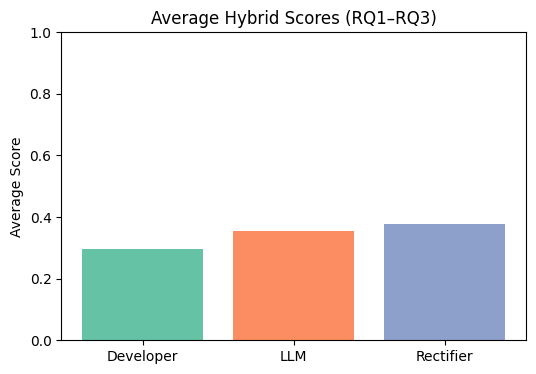

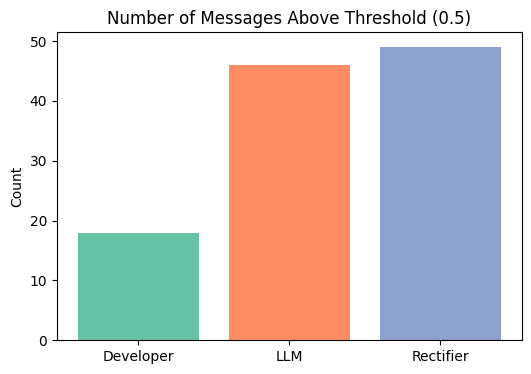

In [29]:
import matplotlib.pyplot as plt

# -----------------------------
# Bar plot 1: Average scores
# -----------------------------
plt.figure(figsize=(6, 4))
plt.bar(["Developer", "LLM", "Rectifier"], [RQ1, RQ2, RQ3], color=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("Average Hybrid Scores (RQ1–RQ3)")
plt.ylabel("Average Score")
plt.ylim(0, 1)
plt.show()

# -----------------------------
# Bar plot 2: Count above threshold
# -----------------------------
threshold = 0.5
counts = [
    (res.dev > threshold).sum(),
    (res.llm > threshold).sum(),
    (res.rect > threshold).sum()
]

plt.figure(figsize=(6, 4))
plt.bar(["Developer", "LLM", "Rectifier"], counts, color=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title(f"Number of Messages Above Threshold ({threshold})")
plt.ylabel("Count")
plt.show()